# Paper results

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config

from ppdev.fit_evaluate import fit_estimator
from ppdev.utils import load_config, suppress_print
from ppdev.visualization import plot_tree
from ppdev.postprocessing import *

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
RC_DEFAULT = {
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "figure.titlesize": 18,
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.title_fontsize": 16,
    "legend.fontsize": 16,
}

In [4]:
ESTIMATOR_ORDER = ["dt", "dt_switch", "dt_stage_switch", "rnn"]

In [5]:
# These labels requires setting `revert_true_false=True` when calling `plot_tree`!
LABEL_MAPPER_RA = {
    "prev_therapy_No DMARD <= 0.5": r"$A_{t-1} = \mathrm{No DMARD}$",
    "prev_therapy_csDMARD therapy <= 0.5": r"$A_{t-1} = \mathrm{csDMARD}$",
    "prev_therapy_TNF combo <= 0.5": r"$A_{t-1} = \mathrm{TNFc}$",
    "prev_therapy_TNF mono <= 0.5": r"$A_{t-1} = \mathrm{TNFm}$",
    "prev_therapy_non-TNF combo <= 0.5": r"$A_{t-1} = \mathrm{non}$-TNFc",
    "cdai_cat_remission <= 0.5": r"$X_{t}^{\mathrm{CDAI}} = \mathrm{remission}$",
    "cdai_cat_moderate <= 0.5": r"$X_{t}^{\mathrm{CDAI}} = \mathrm{moderate}$",
    "cdai_cat_low <= 0.5": r"$X_{t}^{\mathrm{CDAI}} = \mathrm{low}$",
    "cdai_cat_high <= 0.5": r"$X_{t}^{\mathrm{CDAI}} = \mathrm{high}$",
    "duration_ra <= 3.5": r"$X_{t}^{\mathrm{RA duration}} > 3.5$",
}

In [6]:
THERAPIES_RA = ["JAKc", "JAKm", "No DMARD", "TNFc", "TNFm", "csDMARD", "non-TNFc", "non-TNFm"]

In [ ]:
RESULTS_DIR = "/mimer/NOBACKUP/groups/inpole/ppdev/results/"

## Behavior policy modeling

In [8]:
experiment_dir_ra = RESULTS_DIR + "250408_1957"
experiment_dir_sepsis = RESULTS_DIR + "250408_1958"

In [9]:
scores_ra, _ = collect_results(experiment_dir_ra)
scores_sepsis, _ = collect_results(experiment_dir_sepsis)

In [10]:
table_ra = combine_scoring_tables(
    scores_ra,
    metrics=["roc_auc_ovr", "sce"],
    groupby=["estimator_alias"],
    include_cis=True,
)
table_ra = table_ra.sort_index(key=lambda index: [ESTIMATOR_ORDER.index(x) for x in index])

In [11]:
table_sepsis = combine_scoring_tables(
    scores_sepsis,
    metrics=["roc_auc_ovr", "sce"],
    groupby=["estimator_alias"],
    include_cis=True,
)
table_sepsis = table_sepsis.sort_index(key=lambda index: [ESTIMATOR_ORDER.index(x) for x in index])

In [12]:
print(pd.concat([table_ra, table_sepsis], axis=1).to_latex())

\begin{tabular}{lllll}
\toprule
 & roc_auc_ovr & sce & roc_auc_ovr & sce \\
estimator_alias &  &  &  &  \\
\midrule
dt & 92.0 (91.8, 92.3) & 2.7 (2.6, 2.8) & 86.9 (86.5, 87.3) & 0.4 (0.4, 0.4) \\
dt_switch & 92.8 (92.7, 93.0) & 2.6 (2.5, 2.7) & 86.0 (85.8, 86.2) & 0.5 (0.5, 0.6) \\
dt_stage_switch & 94.9 (94.7, 95.0) & 1.3 (1.2, 1.3) & 86.8 (86.6, 87.0) & 0.5 (0.5, 0.5) \\
rnn & 91.8 (91.7, 92.0) & 2.4 (2.3, 2.5) & 88.1 (88.0, 88.2) & 0.5 (0.5, 0.5) \\
\bottomrule
\end{tabular}



### DT-BSL

In [13]:
estimator_alias = "dt_stage_switch"

config = load_config("../configs/ra.yml")
config["experiment"]["seed"] = 0
config["experiment"]["data_handler"] = "6"
config["experiment"]["valid_size"] = None
config["model_selection"]["refit"] = "roc_auc_ovr_switches"
config["estimators"][estimator_alias]["include_ccp_alphas"] = True
config["estimators"][estimator_alias]["calibrate"] = False

set_config(enable_metadata_routing=True)
with suppress_print():
    pipeline, _ = fit_estimator(config, estimator_alias=estimator_alias)
set_config(enable_metadata_routing=False)

In [14]:
feature_names = [f.split("__")[-1] for f in pipeline.named_steps["preprocessor"].get_feature_names_out()]

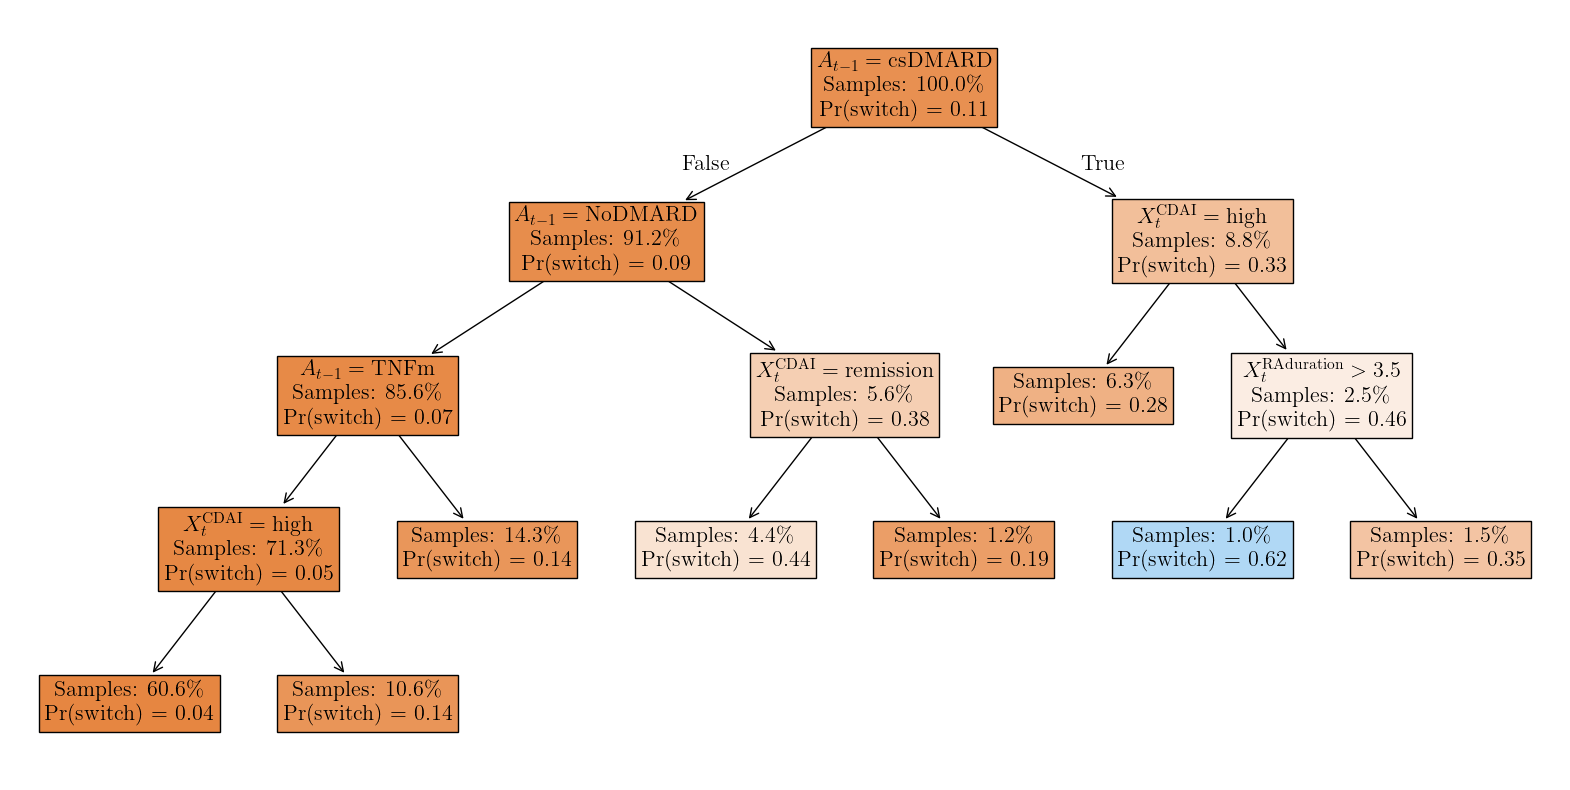

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.rcParams.update(RC_DEFAULT)

def format_labels(samples, value):
    samples = samples.split(" = ")[1][:-1]
    value = value.split(" = ")[1]
    value = value.split(",")[1].replace("]", "").strip()
    value = float(value)
    value = "Pr(switch) = {}".format(value)
    samples = "Samples: {}$\\%$".format(samples)
    return samples, value

plot_tree(
    pipeline.named_steps["estimator"].estimator_s_,
    max_depth=None,
    feature_names=feature_names,
    filled=True,
    proportion=True,
    fontsize=16,
    impurity=False,
    precision=2,
    ax=ax,
    label_mapper=LABEL_MAPPER_RA,
    formatter=format_labels,
    annotate_arrows=True,
    revert_true_false=True,
)

fig.savefig("switch_tree.pdf", dpi=300, bbox_inches="tight", pad_inches=0)

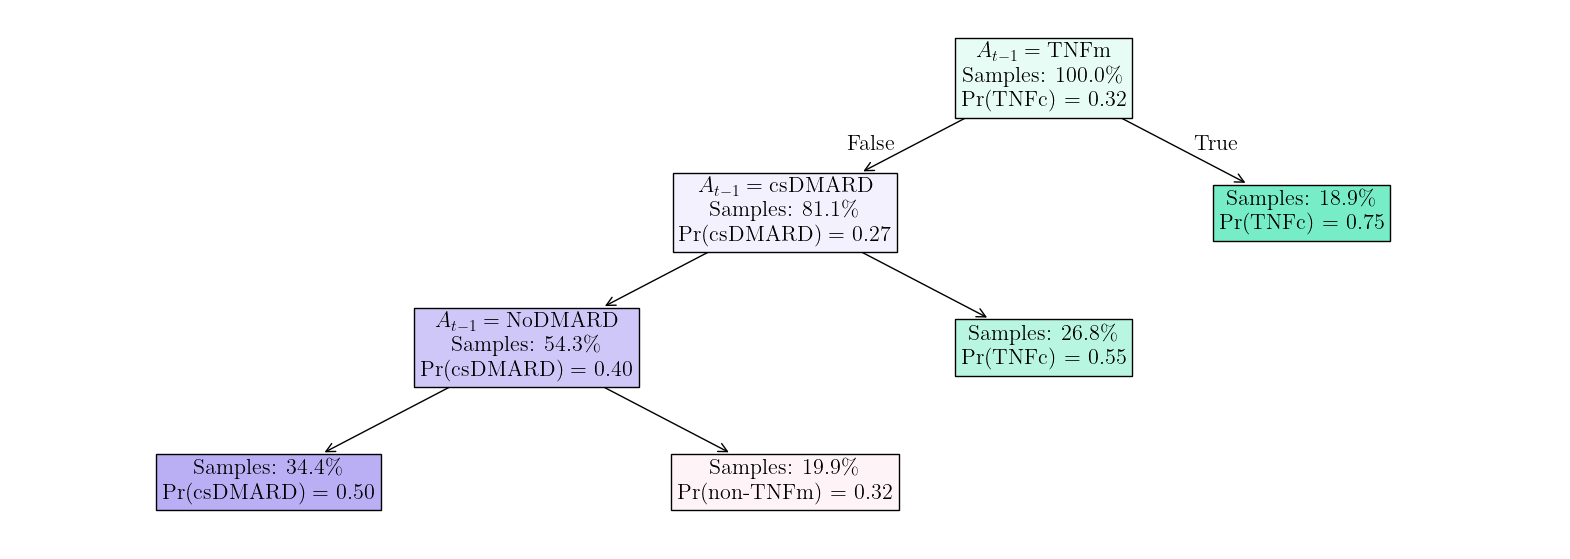

In [16]:
fig, ax = plt.subplots(figsize=(20, 7))

plt.rcParams.update(RC_DEFAULT)

def format_labels(samples, value):
    samples = samples.split(" = ")[1][:-1]
    value = value.split(" = ")[1]
    value = value.removeprefix("[")
    value = value.removesuffix("]")
    value = [float(v) for v in value.split(",")]
    i_max =  np.argmax(value)
    therapy = THERAPIES_RA[i_max]
    value = value[i_max]
    value = "Pr({}) = {:.2f}".format(therapy, value)
    samples = "Samples: {}$\\%$".format(samples)
    return samples, value

plot_tree(
    pipeline.named_steps["estimator"].estimator_t_,
    max_depth=None,
    feature_names=feature_names,
    filled=True,
    proportion=True,
    fontsize=16,
    impurity=False,
    precision=2,
    ax=ax,
    label_mapper=LABEL_MAPPER_RA,
    formatter=format_labels,
    annotate_arrows=True,
    revert_true_false=True,
)

fig.savefig("treatment_tree.pdf", dpi=300, bbox_inches="tight", pad_inches=0)

### DT

In [17]:
estimator_alias = "dt"

config = load_config("../configs/ra.yml")
config["experiment"]["seed"] = 0
config["experiment"]["data_handler"] = "6"
config["experiment"]["valid_size"] = None
config["model_selection"]["refit"] = "roc_auc_ovr_switches"
config["estimators"][estimator_alias]["include_ccp_alphas"] = True
config["estimators"][estimator_alias]["calibrate"] = False

set_config(enable_metadata_routing=True)
with suppress_print():
    pipeline, _ = fit_estimator(config, estimator_alias=estimator_alias)
set_config(enable_metadata_routing=False)

In [18]:
feature_names = [f.split("__")[-1] for f in pipeline.named_steps["preprocessor"].get_feature_names_out()]

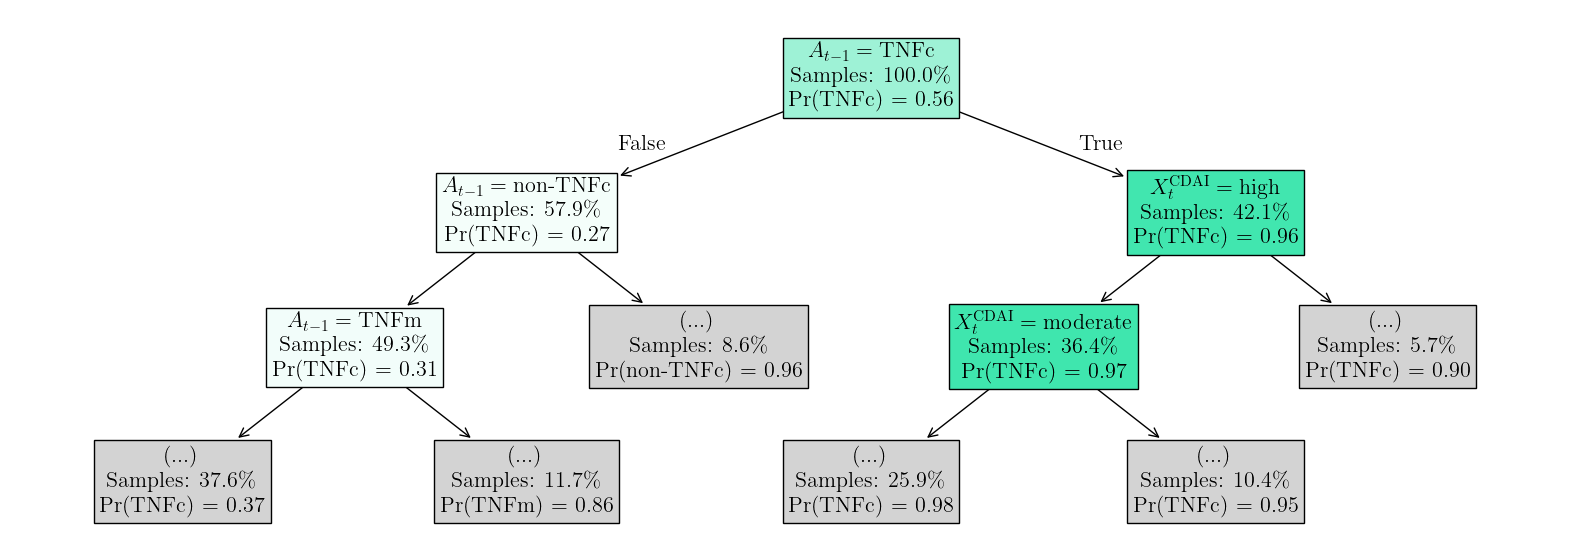

In [19]:
fig, ax = plt.subplots(figsize=(20, 7))

plt.rcParams.update(RC_DEFAULT)

def format_labels(samples, value):
    samples = samples.split(" = ")[1][:-1]
    value = value.split(" = ")[1]
    value = value.removeprefix("[")
    value = value.removesuffix("]")
    value = [float(v) for v in value.split(",")]
    i_max =  np.argmax(value)
    therapy = THERAPIES_RA[i_max]
    value = value[i_max]
    value = "Pr({}) = {:.2f}".format(therapy, value)
    samples = "Samples: {}$\\%$".format(samples)
    return samples, value

estimator = pipeline.named_steps["estimator"]

all_node_ids = range(estimator.tree_.node_count)
node_ids_to_include = [
    i for i in all_node_ids if (
        (i in [0, 1, 2])
        or  (i > 47 and not i in [84, 50, 69])
    )
]

plot_tree(
    estimator,
    max_depth=None,
    feature_names=feature_names,
    filled=True,
    proportion=True,
    fontsize=16,
    impurity=False,
    precision=2,
    ax=ax,
    node_ids_to_include=node_ids_to_include,
    label_mapper=LABEL_MAPPER_RA,
    formatter=format_labels,
    annotate_arrows=True,
    revert_true_false=True,
)

fig.savefig("naive_dt.pdf", dpi=300, bbox_inches="tight", pad_inches=0)

## Off-policy evaluation

In [20]:
experiment_dir_ra = RESULTS_DIR + "250408_1957"
experiment_dir_sepsis = RESULTS_DIR + "250408_1958"

In [21]:
ope_estimates_ra = collect_ope_estimates(experiment_dir_ra)

In [22]:
ope_estimates_sepsis = collect_ope_estimates(
    experiment_dir_sepsis,
    estimates_to_recompute=["wis_estimate"],
)

In [23]:
ope_metric = "wis_estimate_"
mu_estimator_alias = pi_estimator_alias = "dt_stage_switch"

(
    ope_estimates_ra[
        ope_estimates_ra.s.isin([-1, 0])
        & ope_estimates_ra.k.isin([-1, 1, 2, 3, 8])
        & ope_estimates_ra.p.isin([-1, 0])
        & ope_estimates_ra.estimator_alias_mu.eq(mu_estimator_alias)
        & (
            ope_estimates_ra.estimator_alias_pi.eq(pi_estimator_alias)
            # Include policies not derived from a model:
            | pd.isna(ope_estimates_ra.estimator_alias_pi)
        )
    ]
    .groupby(["target_policy", "k"])[[ope_metric, "ess_"]].apply(
        lambda x: (
            f"{x[ope_metric].median():.1f} ({x[ope_metric].quantile(0.25):.1f}, {x[ope_metric].quantile(0.75):.1f})"
            " & "
            f"{x.ess_.median():.1f} ({x.ess_.quantile(0.25):.1f}, {x.ess_.quantile(0.75):.1f})"
        )
    )
)

target_policy  k   
most_likely     1.0       0.7 (0.4, 0.8) & 406.1 (388.1, 415.6)
                2.0      0.0 (-0.2, 0.2) & 566.1 (553.3, 575.0)
                3.0    -0.5 (-0.6, -0.2) & 639.2 (624.6, 650.3)
                8.0    -1.1 (-1.2, -1.0) & 779.0 (770.3, 788.8)
outcome         1.0       0.7 (0.4, 0.8) & 406.1 (388.1, 415.6)
                2.0           1.2 (0.1, 2.7) & 19.2 (7.4, 31.7)
                3.0           3.2 (0.8, 4.1) & 17.1 (9.0, 25.7)
                8.0            5.5 (2.9, 6.4) & 8.1 (2.9, 19.1)
random         -1.0            2.7 (-3.3, 6.2) & 1.1 (1.0, 1.9)
rl             -1.0           -0.0 (-4.2, 3.7) & 3.0 (2.1, 4.3)
rl_bcq         -1.0          -1.8 (-4.6, 0.4) & 7.3 (4.4, 10.5)
rl_cql         -1.0          -0.9 (-5.3, 1.2) & 5.7 (2.8, 11.4)
rl_dqn         -1.0           -0.0 (-4.3, 3.0) & 5.3 (2.4, 9.5)
dtype: object

In [24]:
ope_metric = "wis_estimate_"
mu_estimator_alias = pi_estimator_alias = "dt_stage_switch"

(
    ope_estimates_sepsis[
        ope_estimates_sepsis.s.isin([-1, 0])
        & ope_estimates_sepsis.k.isin([-1, 1, 2, 3, 25])
        & ope_estimates_sepsis.p.isin([-1, 0.01])
        & ope_estimates_sepsis.estimator_alias_mu.eq(mu_estimator_alias)
        & (
            ope_estimates_sepsis.estimator_alias_pi.eq(pi_estimator_alias)
            # Include policies not derived from a model:
            | pd.isna(ope_estimates_sepsis.estimator_alias_pi)
        )
    ]
    .groupby(["target_policy", "k"])[[ope_metric, "ess_"]].apply(
        lambda x: (
            f"{x[ope_metric].median():.1f} ({x[ope_metric].quantile(0.25):.1f}, {x[ope_metric].quantile(0.75):.1f})"
            " & "
            f"{x.ess_.median():.1f} ({x.ess_.quantile(0.25):.1f}, {x.ess_.quantile(0.75):.1f})"
        )
    )
)

target_policy  k    
most_likely     1.0           74.1 (66.8, 82.9) & 64.1 (46.1, 80.8)
                2.0        74.6 (72.0, 79.4) & 277.7 (250.6, 296.0)
                3.0        75.1 (73.7, 76.6) & 628.9 (604.9, 647.7)
                25.0    71.6 (70.7, 72.2) & 2297.0 (2297.0, 2297.0)
outcome         1.0           74.1 (66.8, 82.9) & 64.1 (46.1, 80.8)
                2.0            80.7 (75.7, 93.9) & 15.5 (7.8, 24.7)
                3.0             85.3 (68.5, 95.5) & 6.9 (3.0, 14.2)
                25.0                nan (nan, nan) & nan (nan, nan)
random         -1.0              95.6 (64.4, 99.2) & 1.4 (1.1, 2.0)
rl             -1.0            86.0 (80.3, 92.3) & 14.0 (6.8, 24.5)
rl_bcq         -1.0           83.0 (76.3, 88.2) & 19.3 (12.7, 28.9)
rl_cql         -1.0             67.3 (34.4, 85.2) & 6.5 (2.7, 11.5)
rl_dqn         -1.0              89.3 (70.9, 98.9) & 1.7 (1.1, 8.0)
dtype: object

### RA results

In [25]:
ope_metric = "wis_estimate_"
mu_estimator_alias = pi_estimator_alias = "dt_stage_switch"

data = ope_estimates_ra[
    ope_estimates_ra.target_policy.isin(["outcome", "most_likely"])
    & ope_estimates_ra.estimator_alias_mu.eq(mu_estimator_alias)
    & ope_estimates_ra.estimator_alias_pi.eq(pi_estimator_alias)
].copy()

baseline = data[
    data.target_policy.eq("most_likely")
    & data.k.eq(8)
].groupby("s")[ope_metric].median()

data[f"{ope_metric}_normalized"] = data.groupby(["target_policy", "seed", "s"], group_keys=False).apply(
    lambda x: baseline.xs(x.s.iat[0]) - x[ope_metric]
)

data["k"] = data.k.astype(int)

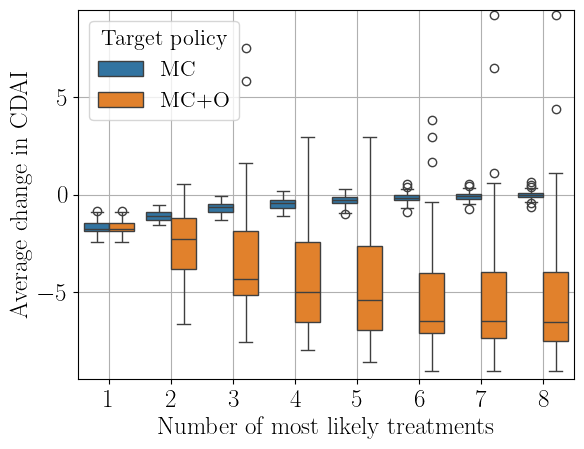

In [26]:
fig, ax = plt.subplots()

plt.rcParams.update(RC_DEFAULT)

sns.boxplot(
    data=data[data.s.eq(0)],
    x="k",
    y=f"{ope_metric}_normalized",
    hue="target_policy",
    hue_order=["most_likely", "outcome"],
    ax=ax,
)
ax.grid("on")
ax.set_xlabel(r"Number of most likely treatments")
ax.set_ylabel("Average change in CDAI")
ax.set_ylim([-9.5, 9.5])

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["MC", "MC+O"])

sns.move_legend(ax, "best", title="Target policy")

fig.savefig("ope_results_ra.pdf", dpi=300, bbox_inches="tight", pad_inches=0)

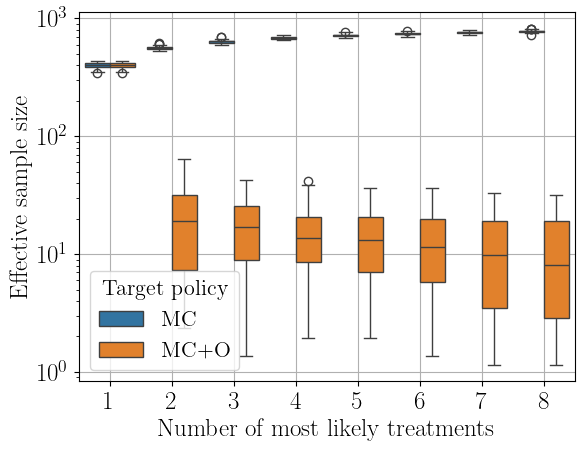

In [27]:
fig, ax = plt.subplots()

plt.rcParams.update(RC_DEFAULT)

sns.boxplot(
    data=data[data.s.eq(0)],
    x="k",
    y="ess_",
    hue="target_policy",
    hue_order=["most_likely", "outcome"],
    ax=ax,
)
ax.grid("on")
ax.set_xlabel(r"Number of most likely treatments")
ax.set_ylabel("Effective sample size")

ax.set_yscale("log")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["MC", "MC+O"])

sns.move_legend(ax, "best", title="Target policy")

fig.savefig("ess_ra.pdf", dpi=300, bbox_inches="tight", pad_inches=0.05)

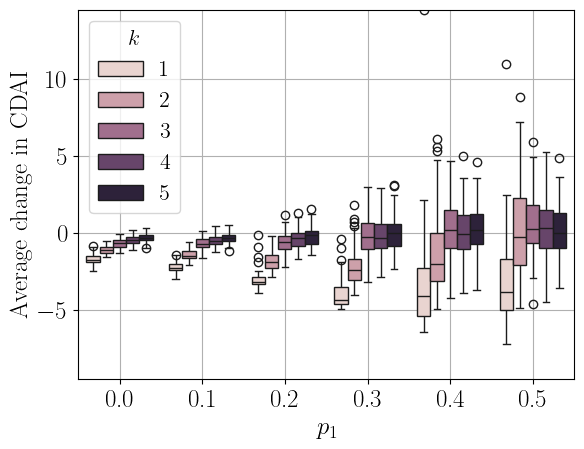

In [28]:
fig, ax = plt.subplots()

plt.rcParams.update(RC_DEFAULT)

sns.boxplot(
    data=data[
        data.target_policy.eq("most_likely")
        & data.k.le(5)
    ],
    x="s",
    y=f"{ope_metric}_normalized",
    hue="k",
    ax=ax,
)
ax.grid("on")
ax.set_xlabel(r"$p_1$")
ax.set_ylabel("Average change in CDAI")
ax.set_ylim([-9.5, 14.5])

sns.move_legend(ax, "best", title=r"$k$", ncol=1)

fig.savefig("ope_results_switch_ra.pdf", dpi=300, bbox_inches="tight", pad_inches=0)

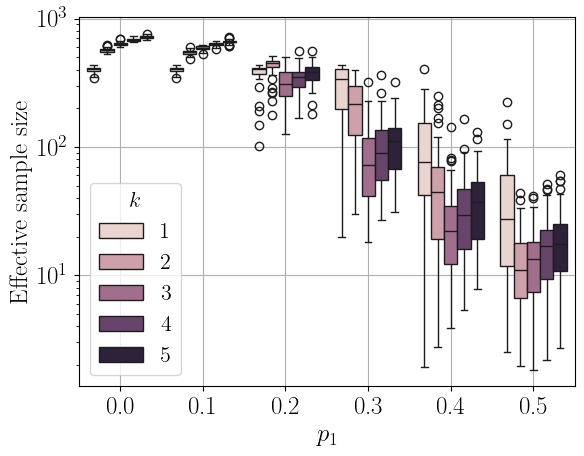

In [29]:
fig, ax = plt.subplots()

plt.rcParams.update(RC_DEFAULT)

sns.boxplot(
    data=data[
        data.target_policy.eq("most_likely")
        & data.k.le(5)
    ],
    x="s",
    y="ess_",
    hue="k",
    hue_order=["most_likely", "outcome"],
    ax=ax,
)
ax.grid("on")
ax.set_xlabel(r"$p_1$")
ax.set_ylabel("Effective sample size")

ax.set_yscale("log")

sns.move_legend(ax, "best", title="$k$")

fig.savefig("ess_switch_ra.pdf", dpi=300, bbox_inches="tight", pad_inches=0.05)